In [1]:
#Importing all libraries
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

### Utilize Linear and Non-Linear (polynomial) regression models to compare trends for a single state and its counties (top 5 with highest number of cases).

In [2]:
#Getting the data of the California state from large covid dataset

#Reading the merged dataset and dropping the rows where countyFIPS = 0
state_covid_data = pd.read_csv("../../../data/stage_1/long_large_covid.csv")

#Changing the format of the date in the data frame
state_covid_data['Date'] = state_covid_data.Date.apply(lambda d: datetime.strptime(d, '%Y-%m-%d'))

#case_ind = state_covid_data[state_covid_data['countyFIPS'] == 0].index
state_covid_data.drop(state_covid_data[state_covid_data['countyFIPS']==0].index, inplace=True)

#Reading the data which belongs to the state California
CA_state_data = state_covid_data[state_covid_data['State'] == 'CA']
CA_state_data

,countyFIPS,County Name,State,StateFIPS,Date,Cases,Death,Population
109443,6001,Alameda County,CA,6,2020-01-22,0,0,1671329
109444,6001,Alameda County,CA,6,2020-01-23,0,0,1671329
109445,6001,Alameda County,CA,6,2020-01-24,0,0,1671329
109446,6001,Alameda County,CA,6,2020-01-25,0,0,1671329
109447,6001,Alameda County,CA,6,2020-01-26,0,0,1671329
...,...,...,...,...,...,...,...,...
142672,6115,Yuba County,CA,6,2021-08-12,7061,49,78668
142673,6115,Yuba County,CA,6,2021-08-13,7126,49,78668
142674,6115,Yuba County,CA,6,2021-08-14,7126,49,78668
142675,6115,Yuba County,CA,6,2021-08-15,7126,49,78668


In [3]:
CA_state_data = CA_state_data.groupby(["Date"]).sum().reset_index()

In [4]:
#Getting the number of cases and deaths per day among all counties in California state

#Writing the number of cases and deaths per day by finding the difference between the rows.
CA_state_data['cases_per_day'] = CA_state_data['Cases'].diff()
CA_state_data['deaths_per_day'] = CA_state_data['Death'].diff()

CA_state_data = CA_state_data[CA_state_data.Date != '2020-01-22']
CA_state_data1 = CA_state_data
CA_state_data

,Date,countyFIPS,StateFIPS,Cases,Death,Population,cases_per_day,deaths_per_day
1,2020-01-23,351364,348,0,0,39512223,0.0,0.0
2,2020-01-24,351364,348,0,0,39512223,0.0,0.0
3,2020-01-25,351364,348,0,0,39512223,0.0,0.0
4,2020-01-26,351364,348,2,0,39512223,2.0,0.0
5,2020-01-27,351364,348,3,0,39512223,1.0,0.0
...,...,...,...,...,...,...,...,...
568,2021-08-12,351364,348,3979630,63875,39512223,10448.0,57.0
569,2021-08-13,351364,348,3993637,63936,39512223,14007.0,61.0
570,2021-08-14,351364,348,3993637,63936,39512223,0.0,0.0
571,2021-08-15,351364,348,3993637,63936,39512223,0.0,0.0


### X-Axis - number of days since the first case, Y - Axis number of new cases and deaths. Calcluate error using RMSE.

In [5]:
def day_since_firstcase(df):
    index = df.index[(df['cases_per_day']>0)]
    case_index = index[0]
    df["Date1"] = df["Date"].iloc[case_index]
    df["Date1"]=df["Date1"].iloc[0]
    df["Date1"]=pd.to_datetime(df['Date1'], format='%Y-%m-%d')
    df["no_of_days_from_first_date"]=df["Date"]-df["Date1"]
    df["no_of_days_from_first_date"] = df["no_of_days_from_first_date"].astype(str).replace("days","",regex=True)
    df["no_of_days_from_first_date"] = df["no_of_days_from_first_date"].astype(int)
    reg_full_dataset = df[['no_of_days_from_first_date','Cases']]

In [6]:
def day_since_firstdeath(df):
    index = df.index[(df['deaths_per_day']>0)]
    case_index = index[0]
    df["Date1"] = df["Date"].iloc[case_index]
    df["Date1"]=df["Date1"].iloc[0]
    df["Date1"]=pd.to_datetime(df['Date1'], format='%Y-%m-%d')
    df["no_of_days_from_first_date"]=df["Date"]-df["Date1"]
    df["no_of_days_from_first_date"] = df["no_of_days_from_first_date"].astype(str).replace("days","",regex=True)
    df["no_of_days_from_first_date"] = df["no_of_days_from_first_date"].astype(int)
    reg_full_dataset = CA_state_data[['no_of_days_from_first_date','Death']]

In [7]:
day_since_firstcase(CA_state_data)
CA_cases = CA_state_data[['no_of_days_from_first_date','cases_per_day']]
CA_cases[CA_cases["no_of_days_from_first_date"]<0]=0
CA_cases

,no_of_days_from_first_date,cases_per_day
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,1.0
...,...,...
568,563,10448.0
569,564,14007.0
570,565,0.0
571,566,0.0


In [8]:
def lin_regression(df):
    X = df.iloc[:,0:1]  
    y = df.iloc[:,1:2]

    # fitting the linear regression model
    lin_reg = LinearRegression().fit(X,y)
    predict = lin_reg.predict(X)
 
    # visualising the linear regression model
    plt.scatter(X,y, color='red')
    plt.plot(X, lin_reg.predict(X),color='blue')
    plt.title("Linear Regression Model")
    plt.xlabel('Number of days since the first case/death')
    plt.ylabel('Number of new cases/deaths')
    plt.show()
    #X = df.iloc[:,0:1].predict((-1,1))    
    
    print('RMSE for Linear Regression:', np.sqrt(mean_squared_error(y,predict)))
    

In [9]:
def poly_regression(df):
    X = df.iloc[:,0:1]  
    y = df.iloc[:,1:2]
    color = ['','','blue','green','yellow']
    for i in range(2,5): 
        poly_reg = PolynomialFeatures(degree=i).fit(X,y)
        predict1 = poly_reg.fit_transform(X)
        total_predict = LinearRegression().fit(predict1,y)
        plt.scatter(X, y, color='red')
        plt.plot(X, total_predict.predict(predict1) , color= color[i], label='Poly Linear Regression with degree %d')
        print('RMSE for Polynomial Regression with degree %d:'%i, np.sqrt(mean_squared_error(y,total_predict.predict(predict1))))

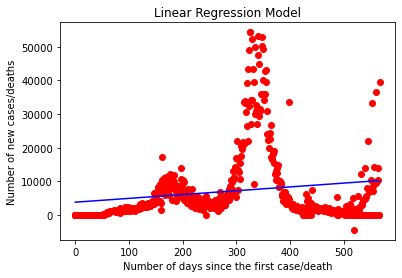

RMSE for Linear Regression: 10476.23830557541


In [10]:
lin_regression(CA_cases)

RMSE for Polynomial Regression with degree 2: 9575.05052634204
RMSE for Polynomial Regression with degree 3: 9525.803271903882
RMSE for Polynomial Regression with degree 4: 8875.273767113391


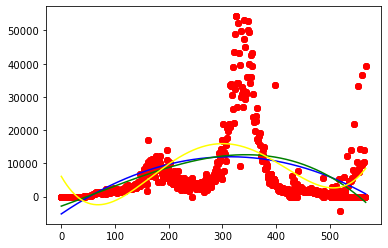

In [11]:
poly_regression(CA_cases)

[[42705.87475439]
 [46749.29999872]
 [51113.27372881]
 [55816.81544634]
 [60879.7940869 ]
 [66322.95730158]
 [72167.96154543]]


Text(0, 0.5, 'Total number of death and cases observed')

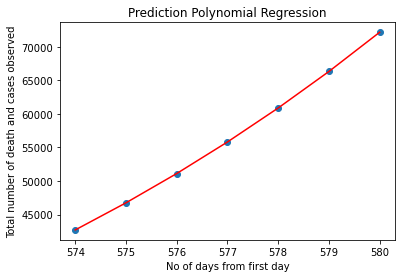

In [12]:
#Prediction of Polynomial regression
x = CA_cases.iloc[:,0:1]  
y = CA_cases.iloc[:,1:2]
poly = PolynomialFeatures(degree = 13)
X_poly = poly.fit_transform(x)
poly.fit(X_poly, y)
lin2 = LinearRegression()
lin2.fit(X_poly, y)
pred2=lin2.predict(X_poly)
h_ploy = np.array([574, 575, 576, 577, 578, 579,580]).reshape((-1, 1))
m_ploy= lin2.predict(poly.fit_transform(h_ploy))
print(m_ploy)
plt.scatter(h_ploy,m_ploy)
plt.plot(h_ploy, lin2.predict(poly.fit_transform(h_ploy)), color = 'red')
plt.title('Prediction Polynomial Regression')
plt.xlabel('No of days from first day')
plt.ylabel('Total number of death and cases observed')

In [13]:
day_since_firstdeath(CA_state_data1)
CA_deaths = CA_state_data1[['no_of_days_from_first_date','deaths_per_day']]
CA_deaths[CA_deaths["no_of_days_from_first_date"]<0]=0
CA_deaths

,no_of_days_from_first_date,deaths_per_day
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
...,...,...
568,552,57.0
569,553,61.0
570,554,0.0
571,555,0.0


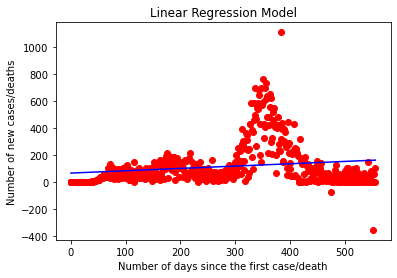

RMSE for Linear Regression: 148.44545350797327


In [14]:
lin_regression(CA_deaths)

RMSE for Polynomial Regression with degree 2: 132.56486847759808
RMSE for Polynomial Regression with degree 3: 125.46921883076848
RMSE for Polynomial Regression with degree 4: 125.40479047246164


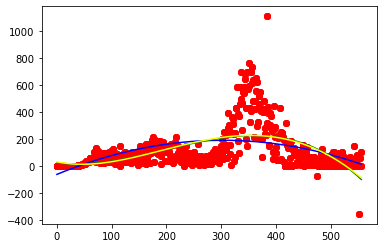

In [15]:
poly_regression(CA_deaths)

[[-472.57735361]
 [-507.51445024]
 [-543.96061282]
 [-581.94937826]
 [-621.51404923]
 [-662.68764535]
 [-705.5028524 ]]


Text(0, 0.5, 'Total number of death and cases observed')

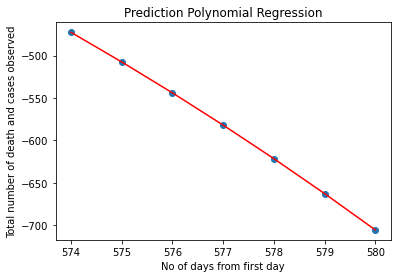

In [16]:
#Prediction of Polynomial regression
x = CA_deaths.iloc[:,0:1]  
y = CA_deaths.iloc[:,1:2]
poly = PolynomialFeatures(degree = 13)
X_poly = poly.fit_transform(x)
poly.fit(X_poly, y)
lin2 = LinearRegression()
lin2.fit(X_poly, y)
pred2=lin2.predict(X_poly)
h_ploy = np.array([574, 575, 576, 577, 578, 579,580]).reshape((-1, 1))
m_ploy= lin2.predict(poly.fit_transform(h_ploy))
print(m_ploy)
plt.scatter(h_ploy,m_ploy)
plt.plot(h_ploy, lin2.predict(poly.fit_transform(h_ploy)), color = 'red')
plt.title('Prediction Polynomial Regression')
plt.xlabel('No of days from first day')
plt.ylabel('Total number of death and cases observed')

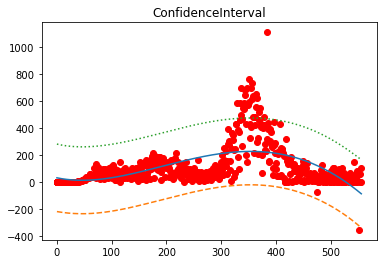

In [18]:
confidence_interval(CA_deaths)

### Identify which counties are most at risk.

In [19]:
state_covid_data

,countyFIPS,County Name,State,StateFIPS,Date,Cases,Death,Population
573,1001,Autauga County,AL,1,2020-01-22,0,0,55869
574,1001,Autauga County,AL,1,2020-01-23,0,0,55869
575,1001,Autauga County,AL,1,2020-01-24,0,0,55869
576,1001,Autauga County,AL,1,2020-01-25,0,0,55869
577,1001,Autauga County,AL,1,2020-01-26,0,0,55869
...,...,...,...,...,...,...,...,...
1829584,56045,Weston County,WY,56,2021-08-12,700,6,6927
1829585,56045,Weston County,WY,56,2021-08-13,700,6,6927
1829586,56045,Weston County,WY,56,2021-08-14,705,6,6927
1829587,56045,Weston County,WY,56,2021-08-15,705,6,6927


In [20]:
CA_data = state_covid_data[state_covid_data['State'] == 'CA']
#Writing the number of cases and deaths per day by finding the difference between the rows.
CA_data['cases_per_day'] = CA_data['Cases'].diff()
CA_data['deaths_per_day'] = CA_data['Death'].diff()
CA_data = CA_data[CA_data.Date != '2020-01-22']
CA_data['cases_rate'] = (CA_data['cases_per_day']/CA_data['Population'])*10000
CA_data1 = CA_data.sort_values(['cases_rate'],ascending=False).head()

In [21]:
CA_data1

,countyFIPS,County Name,State,StateFIPS,Date,Cases,Death,Population,cases_per_day,deaths_per_day,cases_rate
110350,6003,Alpine County,CA,6,2020-12-21,64,0,1129,59.0,0.0,522.586360
110923,6005,Amador County,CA,6,2020-12-21,1771,23,39752,880.0,7.0,221.372510
110310,6003,Alpine County,CA,6,2020-11-11,26,0,1129,23.0,0.0,203.720106
119382,6035,Lassen County,CA,6,2020-08-07,638,0,30573,573.0,0.0,187.420273
124102,6051,Mono County,CA,6,2020-12-21,774,3,14444,262.0,0.0,181.390197


### Model for top 5 counties with cases within a state and describe their trends.

In [22]:
CA = state_covid_data[state_covid_data["State"]=='CA']
CA

,countyFIPS,County Name,State,StateFIPS,Date,Cases,Death,Population
109443,6001,Alameda County,CA,6,2020-01-22,0,0,1671329
109444,6001,Alameda County,CA,6,2020-01-23,0,0,1671329
109445,6001,Alameda County,CA,6,2020-01-24,0,0,1671329
109446,6001,Alameda County,CA,6,2020-01-25,0,0,1671329
109447,6001,Alameda County,CA,6,2020-01-26,0,0,1671329
...,...,...,...,...,...,...,...,...
142672,6115,Yuba County,CA,6,2021-08-12,7061,49,78668
142673,6115,Yuba County,CA,6,2021-08-13,7126,49,78668
142674,6115,Yuba County,CA,6,2021-08-14,7126,49,78668
142675,6115,Yuba County,CA,6,2021-08-15,7126,49,78668


In [23]:
AlpineCounty = CA[CA['countyFIPS'] == 6003]
AmadorCounty = CA[CA['countyFIPS'] == 6005]
LassenCounty = CA[CA['countyFIPS'] == 6035]
MonoCounty = CA[CA['countyFIPS'] == 6051]
YubaCounty = CA[CA['countyFIPS'] == 6115]

In [24]:
AlpineCounty

,countyFIPS,County Name,State,StateFIPS,Date,Cases,Death,Population
110016,6003,Alpine County,CA,6,2020-01-22,0,0,1129
110017,6003,Alpine County,CA,6,2020-01-23,0,0,1129
110018,6003,Alpine County,CA,6,2020-01-24,0,0,1129
110019,6003,Alpine County,CA,6,2020-01-25,0,0,1129
110020,6003,Alpine County,CA,6,2020-01-26,0,0,1129
...,...,...,...,...,...,...,...,...
110584,6003,Alpine County,CA,6,2021-08-12,91,0,1129
110585,6003,Alpine County,CA,6,2021-08-13,91,0,1129
110586,6003,Alpine County,CA,6,2021-08-14,91,0,1129
110587,6003,Alpine County,CA,6,2021-08-15,91,0,1129


In [25]:
AlpineCounty = AlpineCounty.groupby(["Date"]).sum().reset_index()
AlpineCounty['cases_per_day'] = AlpineCounty['Cases'].diff()
AlpineCounty['deaths_per_day'] = AlpineCounty['Death'].diff()
AlpineCounty = AlpineCounty[AlpineCounty.Date != '2020-01-22']

In [26]:
AlpineCounty

,Date,countyFIPS,StateFIPS,Cases,Death,Population,cases_per_day,deaths_per_day
1,2020-01-23,6003,6,0,0,1129,0.0,0.0
2,2020-01-24,6003,6,0,0,1129,0.0,0.0
3,2020-01-25,6003,6,0,0,1129,0.0,0.0
4,2020-01-26,6003,6,0,0,1129,0.0,0.0
5,2020-01-27,6003,6,0,0,1129,0.0,0.0
...,...,...,...,...,...,...,...,...
568,2021-08-12,6003,6,91,0,1129,0.0,0.0
569,2021-08-13,6003,6,91,0,1129,0.0,0.0
570,2021-08-14,6003,6,91,0,1129,0.0,0.0
571,2021-08-15,6003,6,91,0,1129,0.0,0.0


In [27]:
day_since_firstcase(AlpineCounty)
AlpineCounty_cases = AlpineCounty[['no_of_days_from_first_date','cases_per_day']]
AlpineCounty_cases[AlpineCounty_cases["no_of_days_from_first_date"]<0]=0
AlpineCounty_cases

,no_of_days_from_first_date,cases_per_day
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
...,...,...
568,499,0.0
569,500,0.0
570,501,0.0
571,502,0.0


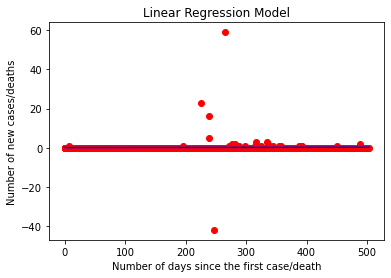

RMSE for Linear Regression: 3.2624696011781413


In [28]:
lin_regression(AlpineCounty_cases)

RMSE for Polynomial Regression with degree 2: 3.2593192133687965
RMSE for Polynomial Regression with degree 3: 3.2587870824499974
RMSE for Polynomial Regression with degree 4: 3.2561913703376


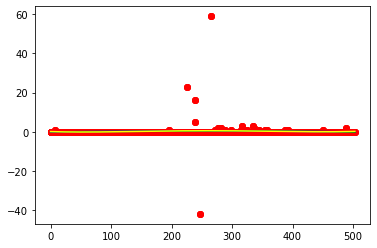

In [29]:
poly_regression(AlpineCounty_cases)

In [30]:
#day_since_firstdeath(AlpineCounty)
#AlpineCounty_deaths = AlpineCounty[['no_of_days_from_first_date','cases_per_day']]
#AlpineCounty_deaths[AlpineCounty_deaths["no_of_days_from_first_date"]<0]=0
#AlpineCounty_deaths


index = AlpineCounty.index[(AlpineCounty['deaths_per_day']>0)]
case_index = 1
AlpineCounty["Date1"] = AlpineCounty["Date"].iloc[case_index]
AlpineCounty["Date1"]=AlpineCounty["Date1"].iloc[0]
AlpineCounty["Date1"]=pd.to_datetime(AlpineCounty['Date1'], format='%Y-%m-%d')
AlpineCounty["no_of_days_from_first_date"]=AlpineCounty["Date"]-AlpineCounty["Date1"]
AlpineCounty["no_of_days_from_first_date"] = AlpineCounty["no_of_days_from_first_date"].astype(str).replace("days","",regex=True)
AlpineCounty["no_of_days_from_first_date"] = AlpineCounty["no_of_days_from_first_date"].astype(int)
reg_full_dataset = CA_state_data[['no_of_days_from_first_date','Death']]

In [31]:
AlpineCounty_Deaths = AlpineCounty[['no_of_days_from_first_date','cases_per_day']]
AlpineCounty_Deaths[AlpineCounty_Deaths["no_of_days_from_first_date"]<0]=0
AlpineCounty_Deaths

,no_of_days_from_first_date,cases_per_day
1,0,0.0
2,0,0.0
3,1,0.0
4,2,0.0
5,3,0.0
...,...,...
568,566,0.0
569,567,0.0
570,568,0.0
571,569,0.0


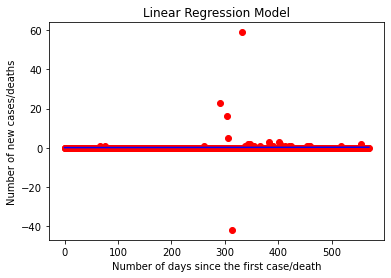

RMSE for Linear Regression: 3.2626591878710443


In [32]:
lin_regression(AlpineCounty_Deaths)

RMSE for Polynomial Regression with degree 2: 3.2601511308166704
RMSE for Polynomial Regression with degree 3: 3.2590737486873818
RMSE for Polynomial Regression with degree 4: 3.2577669062918786


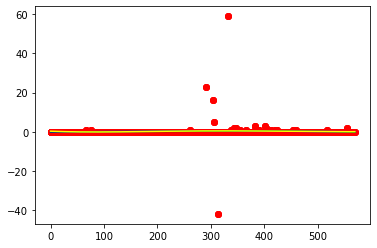

In [33]:
poly_regression(AlpineCounty_Deaths)

In [34]:
#For Amador County

AmadorCounty = AmadorCounty.groupby(["Date"]).sum().reset_index()
AmadorCounty['cases_per_day'] = AmadorCounty['Cases'].diff()
AmadorCounty['deaths_per_day'] = AmadorCounty['Death'].diff()
AmadorCounty = AmadorCounty[AmadorCounty.Date != '2020-01-22']

In [35]:
day_since_firstcase(AmadorCounty)
AmadorCounty_cases = AmadorCounty[['no_of_days_from_first_date','cases_per_day']]
AmadorCounty_cases[AmadorCounty_cases["no_of_days_from_first_date"]<0]=0
AmadorCounty_cases

,no_of_days_from_first_date,cases_per_day
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
...,...,...
568,513,34.0
569,514,34.0
570,515,0.0
571,516,0.0


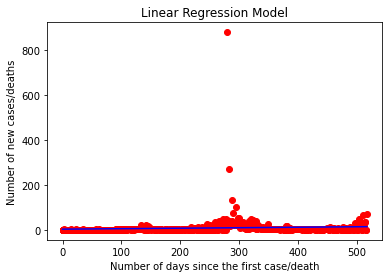

RMSE for Linear Regression: 39.929485891739745


In [36]:
lin_regression(AmadorCounty_cases)

RMSE for Polynomial Regression with degree 2: 39.67887309699622
RMSE for Polynomial Regression with degree 3: 39.655862565807745
RMSE for Polynomial Regression with degree 4: 39.18334536107657


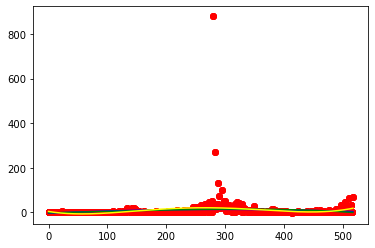

In [37]:
poly_regression(AmadorCounty_cases)

In [38]:
day_since_firstdeath(AmadorCounty)
AmadorCounty_deaths = AmadorCounty[['no_of_days_from_first_date','deaths_per_day']]
AmadorCounty_deaths[AmadorCounty_deaths["no_of_days_from_first_date"]<0]=0
AmadorCounty_deaths

,no_of_days_from_first_date,deaths_per_day
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
...,...,...
568,366,0.0
569,367,0.0
570,368,0.0
571,369,0.0


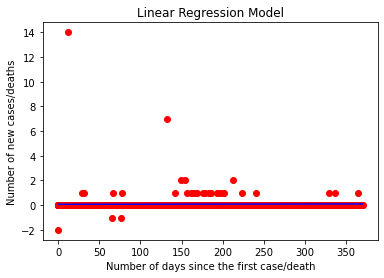

RMSE for Linear Regression: 0.7034896950773037


In [39]:
lin_regression(AmadorCounty_deaths)

RMSE for Polynomial Regression with degree 2: 0.7012323141683513
RMSE for Polynomial Regression with degree 3: 0.700958859710072
RMSE for Polynomial Regression with degree 4: 0.7001666833499353


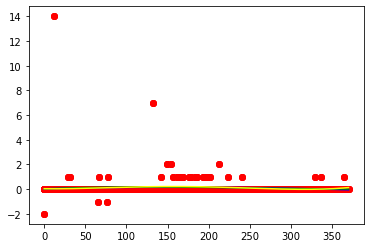

In [40]:
poly_regression(AmadorCounty_deaths)

In [41]:
#For Lassen County

LassenCounty = LassenCounty.groupby(["Date"]).sum().reset_index()
LassenCounty['cases_per_day'] = LassenCounty['Cases'].diff()
LassenCounty['deaths_per_day'] = LassenCounty['Death'].diff()
LassenCounty = LassenCounty[LassenCounty.Date != '2020-01-22']

In [42]:
day_since_firstcase(LassenCounty)
LassenCounty_cases = LassenCounty[['no_of_days_from_first_date','cases_per_day']]
LassenCounty_cases[LassenCounty_cases["no_of_days_from_first_date"]<0]=0
LassenCounty_cases

,no_of_days_from_first_date,cases_per_day
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
...,...,...
568,445,7.0
569,446,20.0
570,447,0.0
571,448,0.0


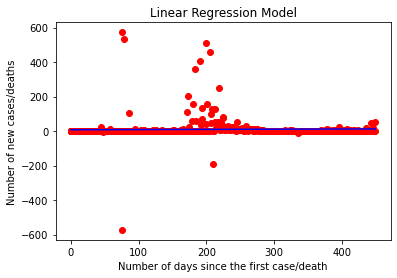

RMSE for Linear Regression: 58.94483012225961


In [43]:
lin_regression(LassenCounty_cases)

RMSE for Polynomial Regression with degree 2: 58.21545554062353
RMSE for Polynomial Regression with degree 3: 58.12578787429662
RMSE for Polynomial Regression with degree 4: 57.64971435811639


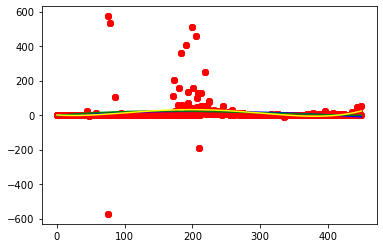

In [44]:
poly_regression(LassenCounty_cases)

In [45]:
day_since_firstdeath(LassenCounty)
LassenCounty_deaths = LassenCounty[['no_of_days_from_first_date','deaths_per_day']]
LassenCounty_deaths[LassenCounty_deaths["no_of_days_from_first_date"]<0]=0
LassenCounty_deaths

,no_of_days_from_first_date,deaths_per_day
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
...,...,...
568,399,0.0
569,400,0.0
570,401,0.0
571,402,0.0


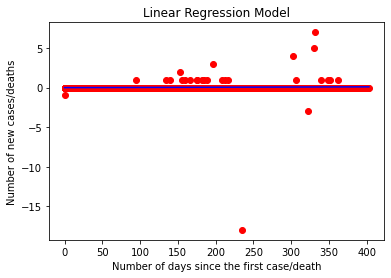

RMSE for Linear Regression: 0.8917521853609528


In [46]:
lin_regression(LassenCounty_deaths)

RMSE for Polynomial Regression with degree 2: 0.8917425517532178
RMSE for Polynomial Regression with degree 3: 0.8916032905754046
RMSE for Polynomial Regression with degree 4: 0.8908897940870698


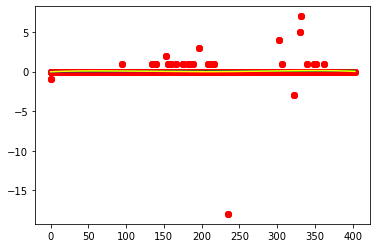

In [47]:
poly_regression(LassenCounty_deaths)

In [48]:
#For Mono County
MonoCounty = MonoCounty.groupby(["Date"]).sum().reset_index()
MonoCounty['cases_per_day'] = MonoCounty['Cases'].diff()
MonoCounty['deaths_per_day'] = MonoCounty['Death'].diff()
MonoCounty = MonoCounty[MonoCounty.Date != '2020-01-22']

In [49]:
day_since_firstcase(MonoCounty)
MonoCounty_cases = MonoCounty[['no_of_days_from_first_date','cases_per_day']]
MonoCounty_cases[MonoCounty_cases["no_of_days_from_first_date"]<0]=0
MonoCounty_cases

,no_of_days_from_first_date,cases_per_day
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
...,...,...
568,509,0.0
569,510,5.0
570,511,0.0
571,512,0.0


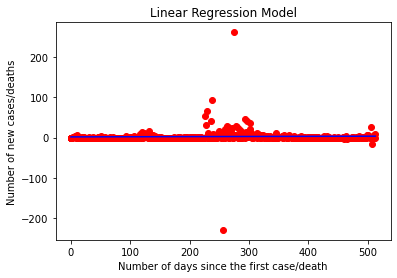

RMSE for Linear Regression: 16.383059839002435


In [50]:
lin_regression(MonoCounty_cases)

RMSE for Polynomial Regression with degree 2: 16.278496971427398
RMSE for Polynomial Regression with degree 3: 16.27400317806656
RMSE for Polynomial Regression with degree 4: 16.192002928500912


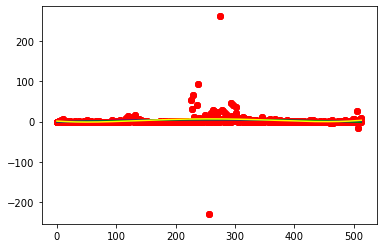

In [51]:
poly_regression(MonoCounty_cases)

In [52]:
day_since_firstdeath(MonoCounty)
MonoCounty_deaths = MonoCounty[['no_of_days_from_first_date','deaths_per_day']]
MonoCounty_deaths[MonoCounty_deaths["no_of_days_from_first_date"]<0]=0
MonoCounty_deaths

,no_of_days_from_first_date,deaths_per_day
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
...,...,...
568,498,0.0
569,499,0.0
570,500,0.0
571,501,0.0


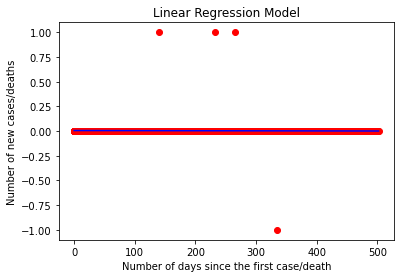

RMSE for Linear Regression: 0.08353737142952543


In [53]:
lin_regression(MonoCounty_deaths)

RMSE for Polynomial Regression with degree 2: 0.08342584493664208
RMSE for Polynomial Regression with degree 3: 0.08334610342900944
RMSE for Polynomial Regression with degree 4: 0.08326704396914854


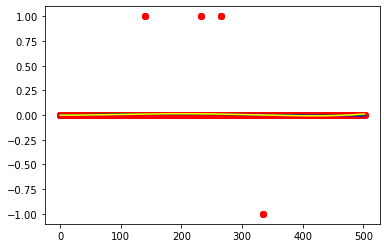

In [54]:
poly_regression(MonoCounty_deaths)

In [55]:
YubaCounty = YubaCounty.groupby(["Date"]).sum().reset_index()
YubaCounty['cases_per_day'] = YubaCounty['Cases'].diff()
YubaCounty['deaths_per_day'] = YubaCounty['Death'].diff()
YubaCounty = YubaCounty[YubaCounty.Date != '2020-01-22']


In [56]:
day_since_firstcase(YubaCounty)
YubaCounty_cases = YubaCounty[['no_of_days_from_first_date','cases_per_day']]
YubaCounty_cases[YubaCounty_cases["no_of_days_from_first_date"]<0]=0
YubaCounty_cases

,no_of_days_from_first_date,cases_per_day
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
...,...,...
568,508,35.0
569,509,65.0
570,510,0.0
571,511,0.0


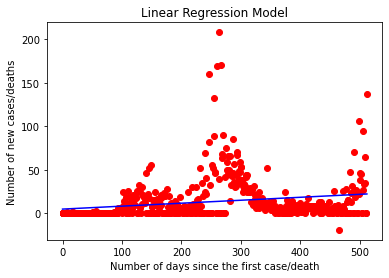

RMSE for Linear Regression: 22.70935729811382


In [57]:
lin_regression(YubaCounty_cases)

RMSE for Polynomial Regression with degree 2: 21.99665938077028
RMSE for Polynomial Regression with degree 3: 21.951174668421714
RMSE for Polynomial Regression with degree 4: 20.38379840488467


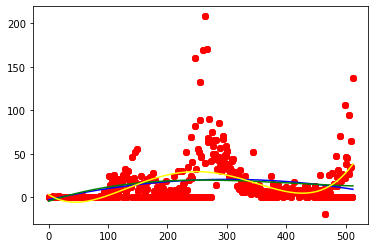

In [58]:
poly_regression(YubaCounty_cases)

In [59]:
day_since_firstdeath(YubaCounty)
YubaCounty_deaths = YubaCounty[['no_of_days_from_first_date','deaths_per_day']]
YubaCounty_deaths[YubaCounty_deaths["no_of_days_from_first_date"]<0]=0
YubaCounty_deaths

,no_of_days_from_first_date,deaths_per_day
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
...,...,...
568,488,0.0
569,489,0.0
570,490,0.0
571,491,0.0


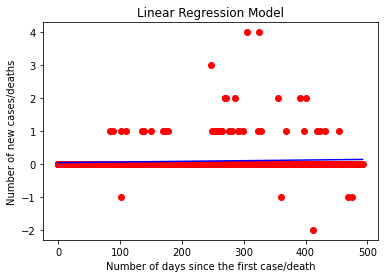

RMSE for Linear Regression: 0.4210797322553833


In [60]:
lin_regression(YubaCounty_deaths)

RMSE for Polynomial Regression with degree 2: 0.41551253779161834
RMSE for Polynomial Regression with degree 3: 0.413568958493949
RMSE for Polynomial Regression with degree 4: 0.41325519987162995


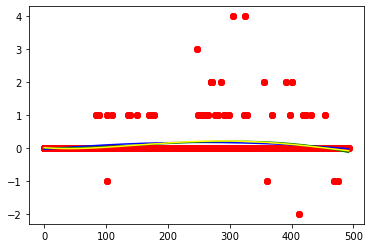

In [61]:
poly_regression(YubaCounty_deaths)

In [80]:
Hospital_dataset = pd.read_csv("../../../data/stage_1/HospMerged.csv")
Hospital_dataset

,Unnamed: 0,countyFIPS,County Name,State,StateFIPS,Date,Cases,Death,Population,hospital_name,...,previous_day_admission_adult_covid_confirmed_7_day_coverage,previous_day_admission_pediatric_covid_confirmed_7_day_coverage,previous_day_admission_adult_covid_suspected_7_day_coverage,previous_day_admission_pediatric_covid_suspected_7_day_coverage,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,total_personnel_covid_vaccinated_doses_one_7_day,total_personnel_covid_vaccinated_doses_all_7_day,previous_week_patients_covid_vaccinated_doses_one_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day
0,2728328,53053,Pierce County,WA,53,2021-06-18,56420,632,904980,ST JOSEPH MEDICAL CENTER,...,7,7,7,7,0.0,0.0,0.0,0.0,0.0,0.0
1,2728329,53053,Pierce County,WA,53,2021-06-18,56420,632,904980,ST ANTHONY HOSPITAL,...,7,7,7,7,0.0,0.0,0.0,0.0,0.0,0.0
2,2728330,53053,Pierce County,WA,53,2021-06-18,56420,632,904980,MARY BRIDGE CHILDREN'S HOSPITAL,...,7,7,7,7,0.0,0.0,0.0,0.0,0.0,0.0
3,2728331,53053,Pierce County,WA,53,2021-06-19,56463,634,904980,MULTICARE GOOD SAMARITAN HOSPITAL,...,7,7,7,7,0.0,0.0,0.0,0.0,0.0,0.0
4,2728332,53053,Pierce County,WA,53,2021-06-19,56463,634,904980,ST CLARE HOSPITAL,...,7,7,7,7,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2828323,56045,Weston County,WY,56,2021-08-12,700,6,6927,WESTON COUNTY HEALTH SERVICES,...,7,7,7,7,6.0,49.0,-999999.0,148.0,0.0,0.0
99996,2828324,56045,Weston County,WY,56,2021-08-13,700,6,6927,WESTON COUNTY HEALTH SERVICES,...,7,7,7,7,6.0,49.0,-999999.0,148.0,0.0,0.0
99997,2828325,56045,Weston County,WY,56,2021-08-14,705,6,6927,WESTON COUNTY HEALTH SERVICES,...,7,7,7,7,6.0,49.0,-999999.0,148.0,0.0,0.0
99998,2828326,56045,Weston County,WY,56,2021-08-15,705,6,6927,WESTON COUNTY HEALTH SERVICES,...,7,7,7,7,6.0,49.0,-999999.0,148.0,0.0,0.0


In [63]:
Hospital_dataset["new_cases"] = Hospital_dataset['Cases'].diff()
Hospital_dataset["new_death"] =Hospital_dataset['Death'].diff()
Hospital_dataset['norm_cases'] = (Hospital_dataset['new_cases']/Hospital_dataset['Population'])*100000
Hospital_dataset['norm_death'] = (Hospital_dataset['new_cases']/Hospital_dataset['Population'])*100000
Hospital_dataset.dropna()
Hospital_dataset

,Unnamed: 0,countyFIPS,County Name,State,StateFIPS,Date,Cases,Death,Population,hospital_name,...,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,total_personnel_covid_vaccinated_doses_one_7_day,total_personnel_covid_vaccinated_doses_all_7_day,previous_week_patients_covid_vaccinated_doses_one_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day,new_cases,new_death,norm_cases,norm_death
0,2728328,53053,Pierce County,WA,53,2021-06-18,56420,632,904980,ST JOSEPH MEDICAL CENTER,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2728329,53053,Pierce County,WA,53,2021-06-18,56420,632,904980,ST ANTHONY HOSPITAL,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,2728330,53053,Pierce County,WA,53,2021-06-18,56420,632,904980,MARY BRIDGE CHILDREN'S HOSPITAL,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,2728331,53053,Pierce County,WA,53,2021-06-19,56463,634,904980,MULTICARE GOOD SAMARITAN HOSPITAL,...,0.0,0.0,0.0,0.0,0.0,0.0,43.0,2.0,4.751486,4.751486
4,2728332,53053,Pierce County,WA,53,2021-06-19,56463,634,904980,ST CLARE HOSPITAL,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2828323,56045,Weston County,WY,56,2021-08-12,700,6,6927,WESTON COUNTY HEALTH SERVICES,...,6.0,49.0,-999999.0,148.0,0.0,0.0,1.0,0.0,14.436264,14.436264
99996,2828324,56045,Weston County,WY,56,2021-08-13,700,6,6927,WESTON COUNTY HEALTH SERVICES,...,6.0,49.0,-999999.0,148.0,0.0,0.0,0.0,0.0,0.000000,0.000000
99997,2828325,56045,Weston County,WY,56,2021-08-14,705,6,6927,WESTON COUNTY HEALTH SERVICES,...,6.0,49.0,-999999.0,148.0,0.0,0.0,5.0,0.0,72.181319,72.181319
99998,2828326,56045,Weston County,WY,56,2021-08-15,705,6,6927,WESTON COUNTY HEALTH SERVICES,...,6.0,49.0,-999999.0,148.0,0.0,0.0,0.0,0.0,0.000000,0.000000


### Perform hypothesis tests

In [64]:
correlation = Hospital_dataset.corr()
correlation

,Unnamed: 0,countyFIPS,StateFIPS,Cases,Death,Population,zip,fips_code,is_metro_micro,total_beds_7_day_avg,...,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,total_personnel_covid_vaccinated_doses_one_7_day,total_personnel_covid_vaccinated_doses_all_7_day,previous_week_patients_covid_vaccinated_doses_one_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day,new_cases,new_death,norm_cases,norm_death
Unnamed: 0,1.000000,0.895782,0.877275,0.039581,0.013780,-0.041123,0.213176,0.895782,-0.172822,-0.164826,...,-0.196023,-0.000349,-0.041132,0.016145,-0.086324,-0.122338,0.001074,0.001054,0.000827,0.000827
countyFIPS,0.895782,1.000000,0.998835,0.029036,-0.013610,-0.040768,0.070030,1.000000,-0.179799,-0.289759,...,-0.241019,-0.027061,-0.097785,0.076204,-0.174123,-0.145279,0.001183,0.001021,0.001161,0.001161
StateFIPS,0.877275,0.998835,1.000000,0.023700,-0.019736,-0.046946,0.071137,0.998835,-0.182019,-0.290879,...,-0.248788,-0.026856,-0.103102,0.079296,-0.184270,-0.148392,0.001148,0.000972,0.001035,0.001035
Cases,0.039581,0.029036,0.023700,1.000000,0.974861,0.707812,0.039024,0.029036,0.245315,0.069695,...,0.084303,0.029301,0.049242,0.039810,0.075890,0.045327,0.013117,0.012298,0.005861,0.005861
Death,0.013780,-0.013610,-0.019736,0.974861,1.000000,0.746920,0.046376,-0.013610,0.251768,0.095651,...,0.088402,0.032095,0.049055,-0.013188,0.077864,0.050410,0.012387,0.012645,0.005554,0.005554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
previous_week_patients_covid_vaccinated_doses_all_7_day,-0.122338,-0.145279,-0.148392,0.045327,0.050410,0.072086,-0.082325,-0.145279,0.044648,-0.030836,...,-0.039484,-0.012625,0.242254,0.050902,0.490752,1.000000,-0.001729,-0.001596,-0.002039,-0.002039
new_cases,0.001074,0.001183,0.001148,0.013117,0.012387,0.012769,-0.000456,0.001183,0.015889,0.010399,...,0.000780,-0.000064,-0.000189,0.005517,0.002496,-0.001729,1.000000,0.960913,0.762403,0.762403
new_death,0.001054,0.001021,0.000972,0.012298,0.012645,0.012279,-0.000016,0.001021,0.015943,0.011250,...,0.000836,-0.000067,0.000064,0.002825,0.001333,-0.001596,0.960913,1.000000,0.746016,0.746016
norm_cases,0.000827,0.001161,0.001035,0.005861,0.005554,0.006968,-0.003018,0.001161,0.016369,0.003467,...,-0.000676,-0.000787,-0.001474,0.001777,0.002146,-0.002039,0.762403,0.746016,1.000000,1.000000


In [65]:
#Performing hypothesis tests on the identified data

import scipy
from scipy.stats import chi2
contingency_table = pd.crosstab(Hospital_dataset["previous_week_patients_covid_vaccinated_doses_all_7_day"],Hospital_dataset["Cases"])
#Observed Values
Observed_Values = contingency_table.values 
print("Observed Values :-\n",Observed_Values)
b=scipy.stats.chi2_contingency(contingency_table)
Expected_Values = b[3]
print("Expected Values :-\n",Expected_Values)
no_of_rows=len(contingency_table.iloc[0:2,0])
no_of_columns=len(contingency_table.iloc[0,0:2])
ddof=(no_of_rows-1)*(no_of_columns-1)
print("Degree of Freedom:-",ddof)
alpha = 0.05


Observed Values :-
 [[ 315   11    7 ...    0    0    0]
 [8899  633  754 ...   14   42   14]
 [ 113   29   15 ...    0    0    0]
 ...
 [  63    6    2 ...    0    0    0]
 [ 116    6    2 ...    0    0    0]
 [  94    0    8 ...    0    0    0]]
Expected Values :-
 [[3.16983600e+02 2.38081500e+01 2.84208000e+01 ... 4.01100000e-01
  1.20330000e+00 4.01100000e-01]
 [8.90851152e+03 6.69104580e+02 7.98738560e+02 ... 1.12725200e+01
  3.38175600e+01 1.12725200e+01]
 [6.33967200e+01 4.76163000e+00 5.68416000e+00 ... 8.02200000e-02
  2.40660000e-01 8.02200000e-02]
 ...
 [6.33967200e+01 4.76163000e+00 5.68416000e+00 ... 8.02200000e-02
  2.40660000e-01 8.02200000e-02]
 [1.26793440e+02 9.52326000e+00 1.13683200e+01 ... 1.60440000e-01
  4.81320000e-01 1.60440000e-01]
 [1.26793440e+02 9.52326000e+00 1.13683200e+01 ... 1.60440000e-01
  4.81320000e-01 1.60440000e-01]]
Degree of Freedom:- 1


In [66]:
#performing Chi-square test for categorical hypothesis testing

chi_square=sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)])
chi_square_statistic=chi_square[0]+chi_square[1]
print("chi-square statistic:-",chi_square_statistic)
critical_value=chi2.ppf(q=1-alpha,df=ddof)
print('critical_value:',critical_value)
#p-value
p_value=1-chi2.cdf(x=chi_square_statistic,df=ddof)
print('p-value:',p_value)
print('Significance level: ',alpha)
print('Degree of Freedom: ',ddof)
print('chi-square statistic:',chi_square_statistic)
print('critical_value:',critical_value)
if chi_square_statistic>=critical_value:
    print("Reject null hypothesis,There is a relationship between number of people who got vaccinated and number of cases")
else:
    print("Retain null hypothesis,There is no relationship between number of people who got vaccinated and number of cases")
    
if p_value<=alpha:
    print("Reject null hypothesis,There is a relationship between number of people who got vaccinated and number of cases")
else:
    print("Retain null hypothesis,There is no relationship between number of people who got vaccinated and number of cases")

chi-square statistic:- 344.1431490750711
critical_value: 3.841458820694124
p-value: 0.0
Significance level:  0.05
Degree of Freedom:  1
chi-square statistic: 344.1431490750711
critical_value: 3.841458820694124
Reject null hypothesis,There is a relationship between number of people who got vaccinated and number of cases
Reject null hypothesis,There is a relationship between number of people who got vaccinated and number of cases


### Confidence Interval

In [67]:
#Confidence Interval
def confidence_interval(df):
    x = df.iloc[:,0:1]  
    y = df.iloc[:,1:2]
    model = sm.OLS(y, PolynomialFeatures(degree=4).fit_transform(x)).fit()
    ypred = model.predict(PolynomialFeatures(degree=4).fit_transform(x)) 
    ypred.shape
    _, upper,lower = wls_prediction_std(model)
    plt.title('ConfidenceInterval')
    plt.scatter(x,y, color='red')
    plt.plot(x,ypred)
    plt.plot()
    plt.plot(x,upper,'--',label="Upper") 
    plt.plot(x,lower,':',label="Lower")

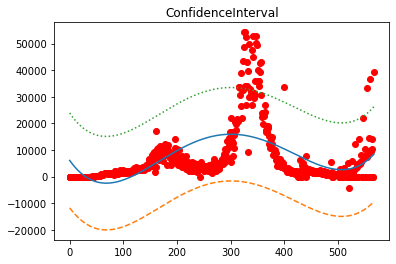

In [68]:
confidence_interval(CA_cases)

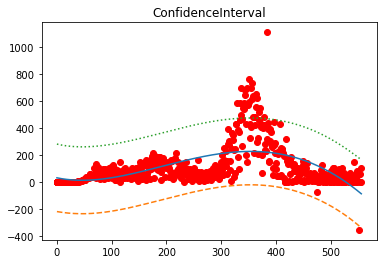

In [69]:
confidence_interval(CA_deaths)

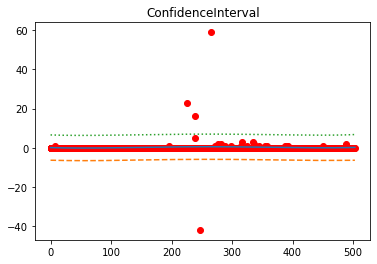

In [70]:
confidence_interval(AlpineCounty_cases)

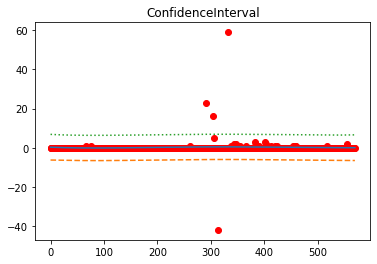

In [71]:
confidence_interval(AlpineCounty_Deaths)

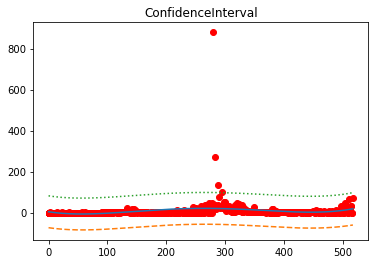

In [72]:
confidence_interval(AmadorCounty_cases)

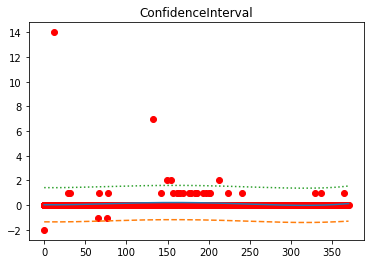

In [73]:
confidence_interval(AmadorCounty_deaths)

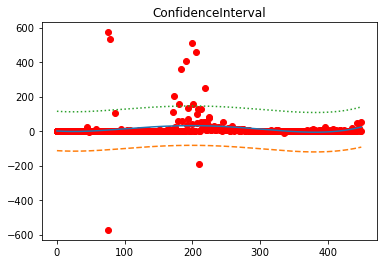

In [74]:
confidence_interval(LassenCounty_cases)

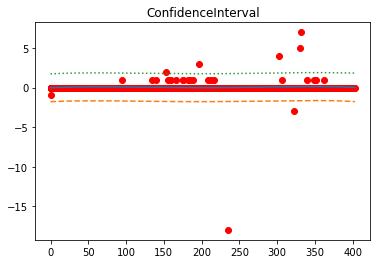

In [75]:
confidence_interval(LassenCounty_deaths)

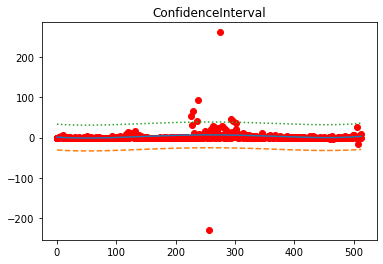

In [76]:
confidence_interval(MonoCounty_cases)

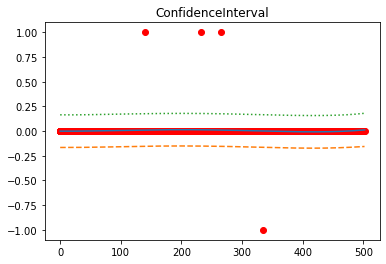

In [77]:
confidence_interval(MonoCounty_deaths)

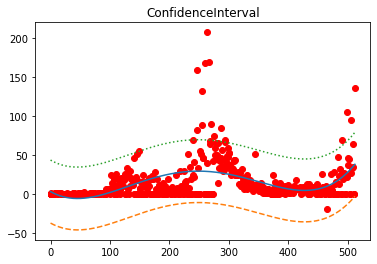

In [78]:
confidence_interval(YubaCounty_cases)

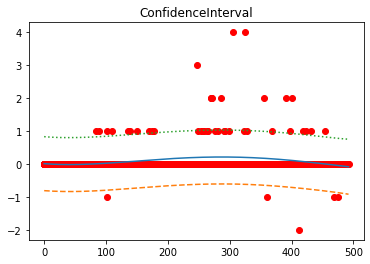

In [79]:
confidence_interval(YubaCounty_deaths)